In [1]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
import pickle
import Estimate_Covariance_Matrix
import os
import prepare_portfolio_data
import portfolio_choice_functions
import scipy.linalg
import functools
import importlib
import cvxpy as cp
import seaborn as sns
sqrtm_cpp = importlib.import_module("sqrtm_cpp")
start_date = pd.to_datetime('1952-12-31')

output_path = "./data_fifty/"
pickle_file_path = "./data_fifty/model_1.pkl"
wealth_path = "./data_fifty/wealth.csv"
barra_file_path = "./data_fifty/barra_cov.pkl"
output_path_market_returns = "data_fifty/market_returns_test.csv"

risk_free_path = "./data_fifty/risk_free_test.csv" 
output_data_ret_csv = "./data_fifty/data_ret.csv"  
output_data_ret_ld1_csv = "./data_fifty/data_ret_ld1.csv"

file_path_cluster_labels = "Data/Cluster Labels.csv"
file_path_factor_details = "Data/Factor Details.xlsx"

risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
daily_path = "./data_fifty/daily.csv"
chars_path = "./data_fifty/chars_behandlet.parquet"


Features list length: 154
Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


In [21]:
#Folder hvor resultater og plots gemmes (hvis du kører Hede så ændrer denne for din :D)
output_folder = r"C:\Users\jonas\OneDrive\CBS\Kandidat - CBS\Speciale\Resultater Python"

## Data indlæsning

In [3]:
wealth = pd.read_csv(wealth_path)
wealth['eom'] = pd.to_datetime(wealth['eom'])
data_ret = pd.read_csv(output_data_ret_csv)
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)
data_ret['eom'] = pd.to_datetime(data_ret['eom'])
data_ret_ld1['eom'] = pd.to_datetime(data_ret_ld1['eom'])
data_ret_ld1['eom_ret'] = pd.to_datetime(data_ret_ld1['eom_ret'])
daily = pd.read_csv(daily_path, parse_dates=["date", "eom"])
chars = pd.read_parquet(chars_path)

In [4]:
with open(barra_file_path, "rb") as file:
    barra_cov = pickle.load(file)

In [5]:
print(barra_cov['2022-11-30']['ivol_vec'])

id
10104    0.004043
10107    0.002393
10138    0.002996
10696    0.003696
11308    0.001280
           ...   
87299    0.004106
87432    0.003534
87447    0.003139
87717    0.003166
92655    0.002555
Name: res_vol, Length: 180, dtype: float64


In [6]:
chars = prepare_portfolio_data.add_return_predictions(chars,settings, output_path)
lambda_list = prepare_portfolio_data.create_lambda_list(chars)
first_cov_date, hp_years, start_oos = prepare_portfolio_data.define_important_dates(barra_cov, settings)
date_ranges = prepare_portfolio_data.create_date_ranges(settings, first_cov_date, start_oos, hp_years)
dates_m1 = date_ranges["dates_m1"]
dates_m2 = date_ranges["dates_m2"]
dates_oos = date_ranges["dates_oos"]
dates_hp = date_ranges["dates_hp"]

#### Check af barra cov

# Illustration af bindende (aktiv) bibetingelse

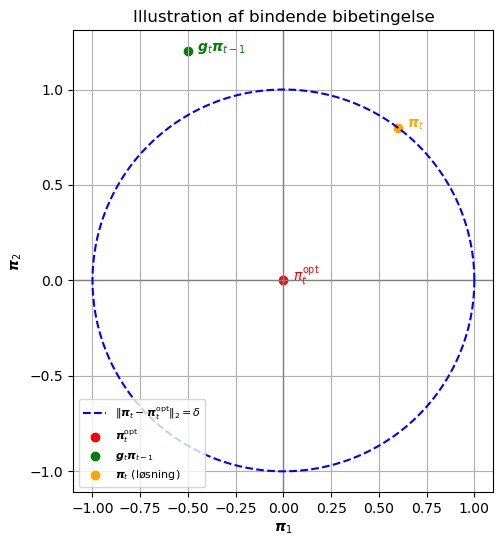

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter for cirklens radius
delta = 1.0

# Opret et grid af vinkler til at tegne en cirkel
theta = np.linspace(0, 2*np.pi, 200)
circle_x = delta * np.cos(theta)
circle_y = delta * np.sin(theta)

# Antag, at den optimale portefølje (pi_opt) er i (0, 0)
pi_opt = np.array([0.0, 0.0])

# Placér cirklens centrum ved pi_opt
circle_center_x = pi_opt[0]
circle_center_y = pi_opt[1]

# Flyt cirklens koordinater til (pi_opt)
circle_x += circle_center_x
circle_y += circle_center_y

# Eksempel: Tidligere portefølje ganget med g_t
# (Her vælger vi bare et eksempelpunkt til illustration)
g_pi_prev = np.array([-0.5, 1.2])

# Eksempel: Den faktiske løsning på randen
# (Igen bare et eksempel)
pi_t = np.array([0.6, 0.8])

# Nu tegner vi det hele
plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linewidth=1)
plt.axvline(0, color='grey', linewidth=1)

# Tegn cirklen (afvigelsesgrænsen)
plt.plot(circle_x, circle_y, 'b--', label=r'$\|\boldsymbol{\pi}_t - \boldsymbol{\pi}_t^{\mathrm{opt}}\|_{2} = \delta$')

# Plot punkterne
plt.scatter(pi_opt[0], pi_opt[1], color='red', label=r'$\boldsymbol{\pi}_t^{\mathrm{opt}}$')
plt.scatter(g_pi_prev[0], g_pi_prev[1], color='green', label=r'$\boldsymbol{g}_t \boldsymbol{\pi}_{t-1}$')
plt.scatter(pi_t[0], pi_t[1], color='orange', label=r'$\boldsymbol{\pi}_t$ (løsning)')

# For overskuelighed kan vi annotere punkter
plt.text(pi_opt[0] + 0.05, pi_opt[1], r'$\pi_t^{\mathrm{opt}}$', color='red')
plt.text(g_pi_prev[0] + 0.05, g_pi_prev[1], r'$\boldsymbol{g}_t \boldsymbol{\pi}_{t-1}$', color='green')
plt.text(pi_t[0] + 0.05, pi_t[1], r'$\boldsymbol{\pi}_t$', color='orange')

# Aksetilpasning og titel
plt.title('Illustration af bindende bibetingelse')
plt.xlabel(r'$\boldsymbol{\pi}_1$')
plt.ylabel(r'$\boldsymbol{\pi}_2$')
plt.gca().set_aspect('equal', adjustable='box')
#plt.legend()
plt.legend(
    loc='lower left',            # placér i nederste venstre hjørne
    bbox_to_anchor=(0.0, 0.0),   # finjustér selve boksen i forhold til hjørnet
    prop={'size': 8},            # gør fonten mindre
    frameon=True,                # evt. True/False for at vise/fjerne ramme
    #title='Min lille legend'     # du kan også give legend-boksen en titel
)
plt.grid(True)
plt.savefig(os.path.join(output_folder, "Bindende_bibetingelse.png"), dpi=300, bbox_inches='tight')
plt.show()


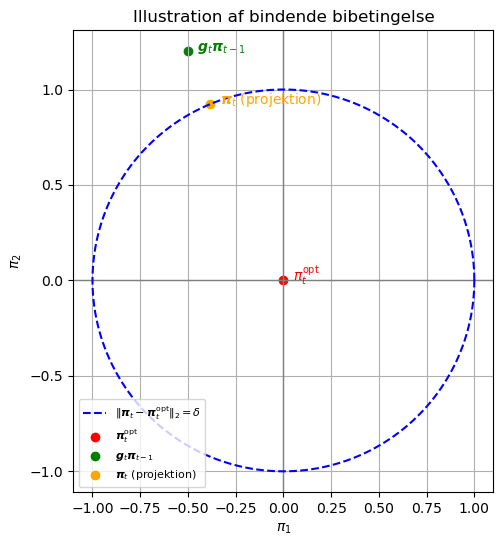

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Parameter for cirklens radius
delta = 1.0

# Opret et grid af vinkler til at tegne en cirkel
theta = np.linspace(0, 2*np.pi, 200)
circle_x = delta * np.cos(theta)
circle_y = delta * np.sin(theta)

# Antag, at den optimale portefølje (pi_opt) er i (0, 0)
pi_opt = np.array([0.0, 0.0])

# Flyt cirklens koordinater til (pi_opt)
circle_x += pi_opt[0]
circle_y += pi_opt[1]

# Eksempel: Tidligere portefølje ganget med g_t
g_pi_prev = np.array([-0.5, 1.2])

# Beregn projektionen på cirklen
direction = g_pi_prev - pi_opt
norm_dir = np.linalg.norm(direction)
if norm_dir == 0:
    unit_dir = np.array([1.0, 0.0])  # tilfældig retning hvis norm=0
else:
    unit_dir = direction / norm_dir
pi_t = pi_opt + delta * unit_dir

# Nu tegner vi det hele
plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linewidth=1)
plt.axvline(0, color='grey', linewidth=1)

# Tegn cirklen (afvigelsesgrænsen)
plt.plot(circle_x, circle_y, 'b--', label=r'$\|\boldsymbol{\pi}_t - \boldsymbol{\pi}_t^{\mathrm{opt}}\|_{2} = \delta$')

# Plot punkterne
plt.scatter(*pi_opt, color='red',   label=r'$\boldsymbol{\pi}_t^{\mathrm{opt}}$')
plt.scatter(*g_pi_prev, color='green', label=r'$\boldsymbol{g}_t \boldsymbol{\pi}_{t-1}$')
plt.scatter(*pi_t,      color='orange', label=r'$\boldsymbol{\pi}_t$ (projektion)')

# Annoter punkter
plt.text(pi_opt[0]  + 0.05, pi_opt[1],  r'$\pi_t^{\mathrm{opt}}$',         color='red')
plt.text(g_pi_prev[0]+ 0.05, g_pi_prev[1], r'$\boldsymbol{g}_t \boldsymbol{\pi}_{t-1}$', color='green')
plt.text(pi_t[0]     + 0.05, pi_t[1],     r'$\boldsymbol{\pi}_t$ (projektion)',    color='orange')

# Aksetilpasning og titel
plt.title('Illustration af bindende bibetingelse')
plt.xlabel(r'$\pi_1$')
plt.ylabel(r'$\pi_2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower left', bbox_to_anchor=(0.0,0.0), prop={'size':8}, frameon=True)
plt.grid(True)

output_folder = '.'  # eller dit ønskede output-folder
plt.savefig(os.path.join(output_folder, "Bindende_bibetingelse.png"), dpi=300, bbox_inches='tight')
plt.show()


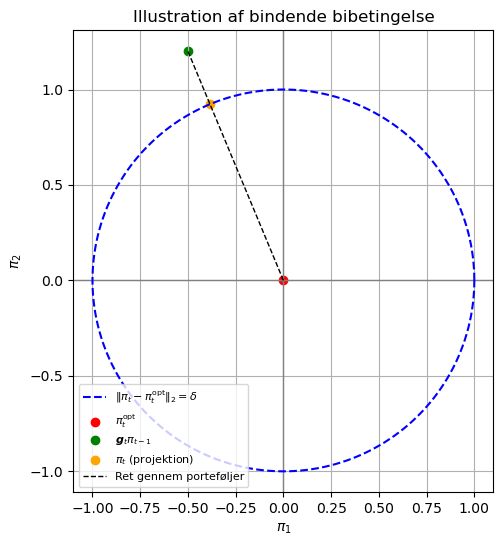

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os

delta = 1.0
theta = np.linspace(0, 2*np.pi, 200)
circle_x = delta * np.cos(theta)
circle_y = delta * np.sin(theta)

pi_opt = np.array([0.0, 0.0])
circle_x += pi_opt[0]; circle_y += pi_opt[1]

g_pi_prev = np.array([-0.5, 1.2])

# Projektion på cirklen
direction = g_pi_prev - pi_opt
norm_dir = np.linalg.norm(direction)
unit_dir = direction/norm_dir if norm_dir>0 else np.array([1.0,0.0])
pi_t = pi_opt + delta*unit_dir

plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linewidth=1)
plt.axvline(0, color='grey', linewidth=1)
plt.plot(circle_x, circle_y, 'b--', label=r'$\|\pi_t - \pi_t^{\rm opt}\|_2=\delta$')
plt.scatter(*pi_opt,      color='red',    label=r'$\pi_t^{\rm opt}$')
plt.scatter(*g_pi_prev,   color='green',  label=r'$\boldsymbol{g}_t \pi_{t-1}$')
plt.scatter(*pi_t,        color='orange', label=r'$\pi_t$ (projektion)')

# Stiplet linje gennem alle tre
points = np.vstack([pi_opt, g_pi_prev, pi_t])
t_vals  = np.dot(points - pi_opt, unit_dir)
t_min, t_max = t_vals.min(), t_vals.max()
t_line = np.linspace(t_min, t_max, 100)
line_x = pi_opt[0] + t_line * unit_dir[0]
line_y = pi_opt[1] + t_line * unit_dir[1]
plt.plot(line_x, line_y, 'k--', linewidth=1, label='Ret gennem porteføljer')

plt.title('Illustration af bindende bibetingelse')
plt.xlabel(r'$\pi_1$')
plt.ylabel(r'$\pi_2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower left', bbox_to_anchor=(0.0,0.0), prop={'size':8}, frameon=True)
plt.grid(True)

plt.savefig(os.path.join(output_folder, "Bindende_bibetingelse.png"), dpi=300, bbox_inches='tight')
plt.show()


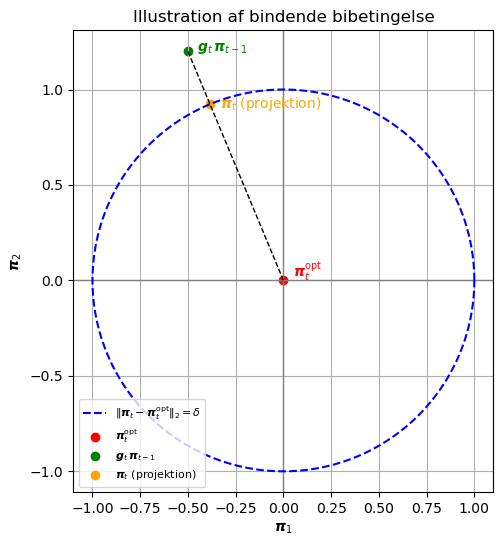

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Parameter for cirklens radius
delta = 1.0

# Opret et grid af vinkler til at tegne en cirkel
theta = np.linspace(0, 2*np.pi, 200)
circle_x = delta * np.cos(theta)
circle_y = delta * np.sin(theta)

# Antag, at den optimale portefølje (pi_opt) er i (0, 0)
pi_opt = np.array([0.0, 0.0])

# Flyt cirklens koordinater til (pi_opt)
circle_x += pi_opt[0]
circle_y += pi_opt[1]

# Eksempel: Tidligere portefølje ganget med g_t
g_pi_prev = np.array([-0.5, 1.2])

# Beregn projektionen af g_pi_prev på cirklen omkring pi_opt
direction = g_pi_prev - pi_opt
norm_dir  = np.linalg.norm(direction)
if norm_dir == 0:
    unit_dir = np.array([1.0, 0.0])  # tilfældig retning hvis punktet er i midten
else:
    unit_dir = direction / norm_dir
pi_t = pi_opt + delta * unit_dir

# Plot setup
plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linewidth=1)
plt.axvline(0, color='grey', linewidth=1)

# Tegn cirklen (afvigelsesgrænsen)
plt.plot(circle_x, circle_y, 'b--',
         label=r'$\|\boldsymbol{\pi}_t - \boldsymbol{\pi}_t^{\mathrm{opt}}\|_{2} = \delta$')

# Plot punkterne
plt.scatter(*pi_opt,      color='red',    label=r'$\boldsymbol{\pi}_t^{\mathrm{opt}}$')
plt.scatter(*g_pi_prev,   color='green',  label=r'$\boldsymbol{g}_t\,\boldsymbol{\pi}_{t-1}$')
plt.scatter(*pi_t,        color='orange', label=r'$\boldsymbol{\pi}_t$ (projektion)')

# Annoter punkterne
plt.text(pi_opt[0]  + 0.05, pi_opt[1]  + 0.02,
         r'$\boldsymbol{\pi}_t^{\mathrm{opt}}$', color='red')
plt.text(g_pi_prev[0] + 0.05, g_pi_prev[1] + 0.00,
         r'$\boldsymbol{g}_t\,\boldsymbol{\pi}_{t-1}$', color='green')
plt.text(pi_t[0]     + 0.05, pi_t[1]     - 0.02,
         r'$\boldsymbol{\pi}_t$ (projektion)', color='orange')

# Tegn stiplede linje gennem alle tre punkter
points = np.vstack([pi_opt, g_pi_prev, pi_t])
t_vals = np.dot(points - pi_opt, unit_dir)
t_min, t_max = t_vals.min(), t_vals.max()
t_line = np.linspace(t_min, t_max, 100)
line_x = pi_opt[0] + t_line * unit_dir[0]
line_y = pi_opt[1] + t_line * unit_dir[1]
#plt.plot(line_x, line_y, 'k--', linewidth=1, label='Ret gennem porteføljer')
plt.plot(line_x, line_y, 'k--', linewidth=1)
# Finpudsning
plt.title('Illustration af bindende bibetingelse')
plt.xlabel(r'$\boldsymbol{\pi}_1$')
plt.ylabel(r'$\boldsymbol{\pi}_2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower left', bbox_to_anchor=(0.0,0.0),
           prop={'size':8}, frameon=True)
plt.grid(True)

# Gem og vis
plt.savefig(os.path.join(output_folder, "Bindende_bibetingelse.png"),
            dpi=300, bbox_inches='tight')
plt.show()
